# Bike Hazards in Madison, WI

### Import Libraries

In [18]:
import pandas as pd
import folium
import matplotlib.pyplot as plt

In [19]:
try:
    import geopy.distance
except:
    !conda install -c conda-forge geopy --yes

import geopy.distance

gdist = lambda g1, g2: geopy.distance.distance(g1, g2).m

In [20]:
# Import Data for Analysis

# Reported Bike Accidents
accidents = pd.read_csv("BicycleAccidents2019.csv")

# Bike Hazards
hazards = pd.read_csv("bike_hazards_madison_subcategories.csv")
hazards.dropna(subset=['Jurisdiction'], inplace = True)

# Hazards Categorized by type
hazard_cat = pd.read_csv("bike_hazards_madison_subcategories.csv")

hazard_cat
hazard_cat.dropna(subset=['Jurisdiction'], inplace = True)

In [21]:
# Map of reported accidents (in red) and listed bike hazards (in blue)

map = folium.Map( location=[43.073051, -89.401230], zoom_start=11 )

for hazard in hazards.itertuples():
    lat = hazard.Y
    lon = hazard.X

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=hazard.Comments,
        color="#377eb8",
        fill=True,
        fill_color="#377eb8",
    fill_opacity=0.7).add_to(map)
    
for accident in accidents.itertuples():
    lat = accident.Latitude
    lon = accident.Longitude

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup="accident",
        color="#e41a1c",
        fill=True,
        fill_color="#e41a1c",
    fill_opacity=0.7).add_to(map)
    
    

# add legend to the map
legend_html = """
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 140px; height: 50px;
     border:2px solid grey; z-index:9999;

     background-color:white;
     opacity: .85;

     font-size:14px;
     font-weight: bold;

     ">
        <svg width="18" height="18"><circle cx="10" cy="10" r="5" stroke="#377eb8" stroke-width="3" fill="#377eb8b3" /></svg> Bike Hazard
        <br />
        <svg width="18" height="18"><circle cx="10" cy="10" r="5" stroke="#e41a1c" stroke-width="3" fill="#e41a1cb3" /></svg> Bike Accident
      </div> """
map.get_root().html.add_child(folium.Element( legend_html ))

map

In [22]:
# this is a function that finds the distance to the closest hazards for a given geo location gloc = (lat, lng)

def dist_to_closest_hazard(gloc):
    
    # initialize with equator length
    min_dist = 40075000
    
    for row in hazards.itertuples():
        dist = gdist( (row.Y, row.X), gloc )
        if dist < min_dist: min_dist = dist

    return dist

In [23]:
# Distance of closest hazard to reported accidents

dist_list = [ ]

for accident in accidents.itertuples():
    dist_list.append( dist_to_closest_hazard( ( accident.Latitude, accident.Longitude ) ) )
    
df = pd.DataFrame({ "distance_to_nearest_hazard": dist_list })
df

,distance_to_nearest_hazard
0,10432.922213
1,10456.111405
2,9430.569668
3,11209.411903
4,10980.213302
...,...
69,5838.269899
70,6237.119827
71,7988.716179
72,8240.270928


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e6da96b70>]],
      dtype=object)

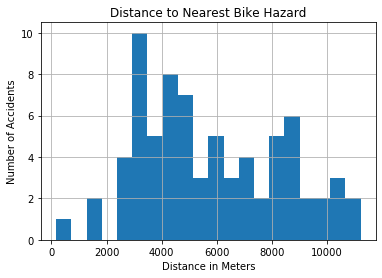

In [25]:
# Histogram of closest hazard distance to reported bike accidents

hist = df.hist(bins=20)

for ax in hist.flatten():
    ax.set_xlabel("Distance in Meters")
    ax.set_ylabel("Number of Accidents")
    ax.set_title("Distance to Nearest Bike Hazard")

hist

Text(0.5, 1.0, 'Number of Hazards by Type')

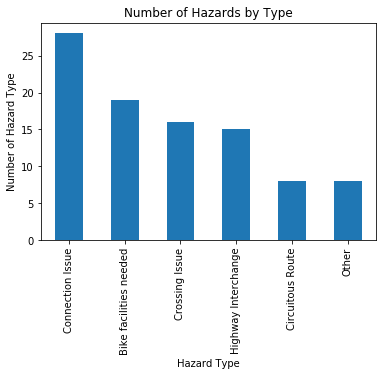

In [26]:
# Bar Chart of the Hazard Categories in Madison 
fig, ax = plt.subplots()
hazard_cat["Hazard_Category"].value_counts().plot.bar(x='lab', y='val', rot=0, ax=ax)
plt.xticks(rotation=90)


ax.set_xlabel("Hazard Type")
ax.set_ylabel("Number of Hazard Type")
ax.set_title("Number of Hazards by Type")


In [27]:
hazard_cat["Hazard_Category"].value_counts()

Connection Issue          28
Bike facilities needed    19
Crossing Issue            16
Highway Interchange       15
Circuitous Route           8
Other                      8
Name: Hazard_Category, dtype: int64

# Hazards do not seem to be connected to accidents? What else could be?

Idea: Use foursquares, get top 5 venue type close to accident and show as tooltips on map.

### Import JSON factors

In [34]:
import requests
from math import sqrt

r = requests.get("https://opendata.arcgis.com/datasets/66e4a6a80ae64865a81bc8d4464a6417_12.geojson")

json = r.json()

# get all the "features" (main type for neighborhood association that stores polygons in geometry)

features = json["features"]

center_points = [ ]
radii = [ ]
for association in features:
    coords = association["geometry"]["coordinates"][0]
    min_lat = min(coords, key=lambda x: x[0])[0]
    max_lat = max(coords, key=lambda x: x[0])[0]
    min_lng = min(coords, key=lambda x: x[1])[1]
    max_lng = max(coords, key=lambda x: x[1])[1]
    center_points.append( ( ( min_lat + max_lat ) / 2, ( min_lng + max_lng ) / 2 ) )
    radii.append(gdist( (min_lat, min_lng), (max_lat, max_lng) ))
    


In [35]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'UH2DFUVQZPL24SWTUACE0S1WNVE3GB0SD4FVEGMZO23L5SP5' # your Foursquare ID
CLIENT_SECRET = '3IOFECNJMO0ARPVGFP0ORZZFNS1TDKYCFEGCRTFD5YVF3ULY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100
RADIUS = 1000

In [38]:
# Get Request and nearby venues from FourSquare

def getNearbyVenues(center_points, radii):
    
    venues_list=[]
    for center_point, radius in zip(center_points, radii):
        print(radius, end="\r")
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            center_point[1], 
            center_point[0], 
            radius, 
            100)
            
        # make the GET request
        ret = requests.get(url).json();
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print("something went wrong", ret)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            radius, 
            center_point[0], 
            center_point[1], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['radius',
                  'lat',
                  'lng',
                  'venue',
                  'venue lat',
                  'venue lng',
                  'venue cat']
    
    return(nearby_venues)


In [39]:
venues = getNearbyVenues(center_points, radii)

In [40]:
# Proportion of most frequent venues

venues_count = venues["venue cat"].value_counts()
venues_percentage = venues_count / venues_count.sum() * 100.
venues_percentage.head()

Pizza Place       4.035948
Sandwich Place    3.709150
Bar               3.627451
Coffee Shop       3.545752
Park              3.415033
Name: venue cat, dtype: float64

In [43]:
# get venues in radius R (in meters) around accident

accident_venues = getNearbyVenues(names=accidents.index,
                                   latitudes=accidents.Latitude,
                                   longitudes=accidents.Longitude)
accident_venues

# one hot encoding of venues
onehot = pd.get_dummies(accident_venues[['venue cat']], prefix="", prefix_sep="")

# add index of accidents back to dataframe (it's called index_hazard in the frame)
onehot["index_accident"] = accident_venues["index_accident"]

# move index_hazard column to the first column
fixed_columns = [ onehot.columns[-1] ] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

grouped = onehot.groupby("index_accident").sum().reset_index()
grouped

# now sort venues per row by frequency

from heapq import nlargest

top5_list = [ ]
top5_accident_indices = [ ]
for row_index, row in grouped.iterrows():
    index = None
    top5 = ", ".join([ tup[0] + " (" + str(tup[1]) + ")" for tup in nlargest(5, row[1:].iteritems(), key=lambda x: x[1]) ])
    top5_list.append(top5)
    top5_accident_indices.append(row.index_accident)

accidents_venue_col = [ "None" ] * (int)((max(top5_accident_indices) + 1).item())
for index, item in zip(top5_accident_indices, top5_list):
     accidents_venue_col[(int)(index.item())] = item

accidents["topvenues"] = accidents_venue_col
accidents.head()

TypeError: getNearbyVenues() got an unexpected keyword argument 'names'

In [42]:
# Type of venue that is closest to most bike accidents

accident_venues_percentage = pd.read_csv("accident_venues_percentage.csv", header=None, squeeze=True)
accident_venues_percentage

,0,1
0,Coffee Shop,3.543914
1,Bar,3.403838
2,Sandwich Place,2.199188
3,Pizza Place,2.031097
4,Hotel,1.905029
...,...,...
256,Preschool,0.014008
257,Print Shop,0.014008
258,Costume Shop,0.014008
259,Medical Supply Store,0.014008


,venue_type,In Madison,Near Accidents
Bar,Bar,3.627451,3.403838
Hotel,Hotel,2.107843,1.905029
American Restaurant,American Restaurant,2.058824,1.498809
Gym / Fitness Center,Gym / Fitness Center,1.241830,0.000000
Ice Cream Shop,Ice Cream Shop,1.258170,0.826446
Café,Café,0.000000,1.372741
Pub,Pub,0.000000,0.840454
New American Restaurant,New American Restaurant,0.000000,1.288696
Music Venue,Music Venue,0.000000,0.896484
Grocery Store,Grocery Store,1.911765,0.000000


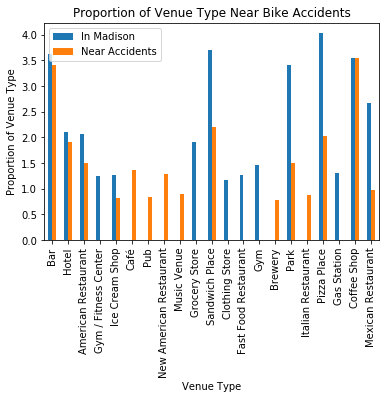

In [44]:
# combine both distributions, but only get top 15 of both

venues_percentage_dict = { }
for venue, count in venues_percentage[:15].iteritems():
    venues_percentage_dict[venue] = count

accident_venues_percentage_dict = { }
for row in accident_venues_percentage[:15].iterrows():
    accident_venues_percentage_dict[row[1][0]] = row[1][1]

venue_types = set(accident_venues_percentage_dict).union(set(venues_percentage_dict))
# fill in everything with 0 that is not mentioned and turn it into list of tuples
l = [ (venue_type, venues_percentage_dict.get(venue_type, 0.0), accident_venues_percentage_dict.get(venue_type, 0.0)) for venue_type in venue_types ]
        
accident_venues = pd.DataFrame(l, columns=[ "venue_type", "In Madison", "Near Accidents" ], index=venue_types)
accident_venues
ax = accident_venues.plot.bar(rot=90)
ax.plot()

ax.set_xlabel("Venue Type")
ax.set_ylabel("Proportion of Venue Type")
ax.set_title("Proportion of Venue Type Near Bike Accidents")

accident_venues

In [17]:
# Histogram shows the proportion of venue type in the city of Madison (in Blue) and the proportion of venue type near bike accidents


,venue_type,in Madison,near accidents
Bar,Bar,3.664495,3.403838
Hotel,Hotel,2.166124,1.905029
American Restaurant,American Restaurant,2.100977,1.498809
Gym / Fitness Center,Gym / Fitness Center,1.335505,0.000000
Ice Cream Shop,Ice Cream Shop,1.188925,0.826446
Café,Café,0.000000,1.372741
Pub,Pub,0.000000,0.840454
New American Restaurant,New American Restaurant,0.000000,1.288696
Music Venue,Music Venue,0.000000,0.896484
Grocery Store,Grocery Store,1.856678,0.000000


In [45]:
# Map of the top 5 venues near accident locations

map = folium.Map( location=[43.073051, -89.401230], zoom_start=11 )

for hazard in hazard_cat.itertuples():
    lat = hazard.Y
    lon = hazard.X

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=folium.Popup(hazard, parse_html=True, max_width=200),
        color="#377eb8",
        fill=True,
        fill_color="#377eb8",
    fill_opacity=0.7).add_to(map)

        
for accident in accidents.itertuples():
    lat = accident.Latitude
    lon = accident.Longitude

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=folium.Popup(accident.topvenues, parse_html=True, max_width=200),
        color="#e41a1c",
        fill=True,
        fill_color="#e41a1c",
    fill_opacity=0.7).add_to(map)
    
    
# add legend to the map
legend_html = """
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 140px; height: 50px;
     border:2px solid grey; z-index:9999;

     background-color:white;
     opacity: .85;

     font-size:14px;
     font-weight: bold;

     ">
        <svg width="18" height="18"><circle cx="10" cy="10" r="5" stroke="#377eb8" stroke-width="3" fill="#377eb8b3" /></svg> bike hazard
        <br />
        <svg width="18" height="18"><circle cx="10" cy="10" r="5" stroke="#e41a1c" stroke-width="3" fill="#e41a1cb3" /></svg> bike accident
      </div> """
map.get_root().html.add_child(folium.Element( legend_html ))

map